In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# IMPORT PACKAGES

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
from scipy import signal
from scipy.stats import skew
from scipy.stats import pearsonr
import matplotlib.ticker as mticker

In [26]:
# CODE TO CALCULATE SEASONAL AVERAGE

# Taken from: https://xarray.pydata.org/en/v0.14.0/examples/monthly-means.html
# However test plot in "Seasonal Mean Example" produces somewhat different results-- not sure why.
# usage example: ds_weighted = season_mean(ds,calendar='noleap')

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def season_mean(ds, calendar='standard'):

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [3]:
# PATHS TO DATA FILES

direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
diag = 't_surf'
diag2 = 'precip'
files = {}
files2 = {}

files['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/'+diag+'.00010101-03000101.atmos_month.nc'
files['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/'+diag+'.00010101-02050101.atmos_month.nc'
files['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/'+diag+'.00010101-06000101.atmos_month.nc'
files['obs'] = '/tigress/gvecchi/DATA/HADISST/HadISST_sst.nc'
files['ctrl_ccsm'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.pop.h.SSTregrid.100001-130012.nc'
files['cam_ccsm'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.pop.h.SSTregrid.000101-029912.nc'
files['ctrl_ccsm_nino'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/b40.1850.track1.1deg.006.pop.h.nino3_nino34.100001-130012.nc'
files['cam_ccsm_nino'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/ccsm4pi_topo2.pop.h.nino3_nino34.000101-029912.nc'

files2['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/'+diag2+'.00010101-03000101.atmos_month.nc'
files2['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/'+diag2+'.00010101-02050101.atmos_month.nc'
files2['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/'+diag2+'.00010101-06000101.atmos_month.nc'
files2['obs'] = '/tigress/janewb/OBS/CMAP/precip.mon.mean.nc'

In [7]:
xr.open_dataset(files['ctrl_ccsm_nino'])

<xarray.Dataset>
Dimensions:  (time: 3612)
Coordinates:
  * time     (time) object 1000-02-01 00:00:00 ... 1301-01-01 00:00:00
Data variables:
    nino3    (time) float32 ...
    nino34   (time) float32 ...
Attributes:
    creation_date:  Fri Mar 27 18:52:24 EDT 2020
    Conventions:    None
    source_file:    writecdf_nino3_nino34_ccsm4picontrol.ncl
    title:          netCDF file containing monthly nino3 and nino3.4 data

In [28]:
# REGIONS FOR AVERAGING

# Nino 3.4 Region
ymin34 = -5
ymax34 = 5
xmin34 = -170+360
xmax34 = -120+360

#Nino 3 Region
ymin3 = -5
ymax3 = 5
xmin3 = -150+360
xmax3 = -90+360

In [29]:
# DATA CLEANING
x = 'lon'
y = 'lat'
sst_var = 'sst'
units = 'C'
units2 = 'mm/day'
model_tmin = '0031'
model_tmax = '0200'
obs_tmin = '1947'
obs_tmax = '2016'
calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'obs':'gregorian',
             'ctrl_ccsm':'noleap',
             'cam_ccsm':'noleap'
            }

dat = {}
sst = {}
tsel = {}
dat2 = {}
tsel2 = {}
pr = {}


# FLOR Runs

for key in ['ctrl','cam','hitopo']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = dat[key].rename({'t_surf':'sst'})
    sst[key] = dat[key].sst-273.15
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    sst[key] = sst[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tsel[key] = sst[key].sel(time = slice(model_tmin,model_tmax))
    
for key in ['ctrl_ccsm']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = dat[key].rename({'sst_regrid':'sst'})
    sst[key] = dat[key].sst
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    tsel[key] = sst[key]#.sel(time = slice(model_tmin,model_tmax))
    
for key in ['cam_ccsm']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = dat[key].rename({'sst_regrid':'sst'})
    sst[key] = dat[key].sst
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    tsel[key] = sst[key]#.sel(time = slice(model_tmin,model_tmax))
    
for key in ['ctrl','cam','hitopo']:
    dat2[key] = xr.open_dataset(files2[key])
    pr[key] = dat2[key].precip*86400
    pr[key].attrs = dat2[key].attrs
    pr[key].attrs['units'] = units2
    pr[key] = pr[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tsel2[key] = pr[key].sel(time = slice(model_tmin,model_tmax))
    
# OBSERVATIONS

# HADISST
dat['obs'] = xr.open_dataset(files['obs'])
dat['obs'] = dat['obs'].rename({'longitude': 'lon','latitude': 'lat'})
dat['obs'] = dat['obs'].sortby('lat', ascending=True)
dat['obs'] = dat['obs'].assign_coords(lon=(dat['obs'].lon % 360)).roll(lon=180, roll_coords=True)
sst['obs'] = dat['obs'].sst
sst['obs'].attrs = dat['obs'].attrs
tsel['obs'] = sst['obs'].sel(time = slice(obs_tmin,obs_tmax))

# CMAP
# dat2['obs'] = xr.open_dataset(files2['obs'])
# pr['obs'] = dat2['obs'].precip
# pr['obs'].attrs = dat2['obs'].attrs
# tsel2['obs'] = pr['obs'].sel(time = slice(obs_tmin,obs_tmax))


In [30]:
# DATA ANALYSIS

tmean = {}
seasmean = {}
nino34_sst = {}
nino3_sst = {}
climatology = {}
anomaly = {}
variance = {}
anom = {}


for key in ['ctrl','cam','hitopo','cam_ccsm','ctrl_ccsm','obs']:
    nino34_sst[key] = tsel[key].sel(lon = slice(xmin34,xmax34)).mean(dim='lon').sel(lat = slice(ymin34,ymax34)).mean(dim='lat')
    nino3_sst[key] = tsel[key].sel(lon = slice(xmin3,xmax3)).mean(dim='lon').sel(lat = slice(ymin3,ymax3)).mean(dim='lat')
    tmean[key] = tsel[key].mean(dim='time')
    seasmean[key] = season_mean(tsel[key],calendar=calendars[key])
    climatology[key] = tsel[key].groupby('time.month').mean('time')
    anomaly[key] = tsel[key].groupby('time.month') - climatology[key]
    variance[key] = anomaly[key].var(dim='time')
    

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


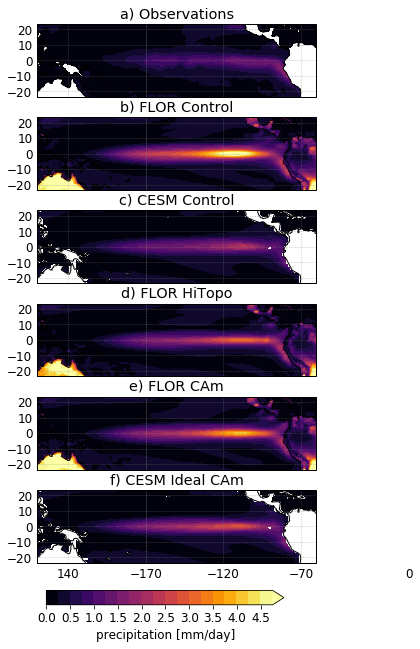

In [43]:
# SST Variance Maps

fig = plt.figure(figsize=(5,10))
plt.rcParams.update({'font.size': 12})

lev = np.arange(0,5,0.25)
cmap = plt.cm.inferno
lw = 0.5
proj = ccrs.PlateCarree(central_longitude=-180)

lonf = variance['ctrl'].lon
latf = variance['ctrl'].lat
lonc = variance['ctrl_ccsm'].lon
latc = variance['ctrl_ccsm'].lat
lono = variance['obs'].lon
lato = variance['obs'].lat

ymax = 23.5
ymin = -23.5
xmin = 120
xmax = 300

ax0 = plt.subplot(6,1,1,projection=proj)
ax0.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im0 = plt.contourf(lono,lato,variance['obs'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax0.coastlines()
ax0.set_title('a) Observations')
g0 = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
g0.xlabels_top = False
g0.xlabels_bottom = False
g0.ylabels_right = False
g0.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
g0.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax1 = plt.subplot(6,1,2,projection=proj)
ax1.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im1 = plt.contourf(lonf,latf,variance['ctrl'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax1.coastlines()
ax1.set_title('b) FLOR Control')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax3 = plt.subplot(6,1,3,projection=proj)
ax3.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im3 = plt.contourf(lonc,latc,variance['ctrl_ccsm'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max',color='k')
ax3.coastlines()
ax3.set_title('c) CESM Control')
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax5 = plt.subplot(6,1,4,projection=proj)
ax5.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im5 = plt.contourf(lonf,latf,variance['hitopo'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax5.coastlines()
ax5.set_title('d) FLOR HiTopo')
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax7 = plt.subplot(6,1,5,projection=proj)
ax7.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im7 = plt.contourf(lonf,latf,variance['cam'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax7.coastlines()
ax7.set_title('e) FLOR CAm')
gl = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax9 = plt.subplot(6,1,6,projection=proj)
ax9.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im9 = plt.contourf(lonc,latc,variance['cam_ccsm'],levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax9.coastlines()
ax9.set_title('f) CESM Ideal CAm')
gl = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.15, 0.07, 0.66, 0.02]) # rect = l, b, w, h
cb1 = fig.colorbar(im1, cax=cb1_ax, orientation = 'horizontal')
cb1.ax.set_xlabel('precipitation [mm/day]', rotation=0)

#plt.tight_layout()

plt.savefig('sstvariancemap.pdf')

In [9]:
# Saved out data so don't have to go through nino34 analysis over and over again

nino34_sst['cam'].to_netcdf('nino34_sst_cam.nc')
nino34_sst['ctrl'].to_netcdf('nino34_sst_ctrl.nc')
nino34_sst['hitopo'].to_netcdf('nino34_sst_hitopo.nc')
nino34_sst['obs'].to_netcdf('nino34_sst_obs.nc')

nino3_sst['cam'].to_netcdf('nino3_sst_cam.nc')
nino3_sst['ctrl'].to_netcdf('nino3_sst_ctrl.nc')
nino3_sst['hitopo'].to_netcdf('nino3_sst_hitopo.nc')
nino3_sst['obs'].to_netcdf('nino3_sst_obs.nc')

KeyError: 'cam'

In [8]:
# PRECIPITATION DATA CLEANING
x = 'lon'
y = 'lat'
units2 = 'mm/day'
model_tmin = '0031'
model_tmax = '0200'
obs_tmin = '1947'
obs_tmax = '2016'
calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'obs':'gregorian'
            }

dat2 = {}
tsel2 = {}
pr = {}


# FLOR Runs
    
for key in ['ctrl','cam','hitopo']:
    dat2[key] = xr.open_dataset(files2[key])
    pr[key] = dat2[key].precip*86400
    pr[key].attrs = dat2[key].attrs
    pr[key].attrs['units'] = units2
    pr[key] = pr[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tsel2[key] = pr[key].sel(time = slice(model_tmin,model_tmax))
    
# OBSERVATIONS

# CMAP
dat2['obs'] = xr.open_dataset(files2['obs'])
pr['obs'] = dat2['obs'].precip
pr['obs'].attrs = dat2['obs'].attrs
tsel2['obs'] = pr['obs'].sel(time = slice(obs_tmin,obs_tmax))


# Start here if revised saved out data already.

In [6]:
# LOAD DATA
files = {}
files['ctrl_ccsm_nino'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/b40.1850.track1.1deg.006.pop.h.nino3_nino34.100001-130012.nc'
files['cam_ccsm_nino'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/ccsm4pi_topo2.pop.h.nino3_nino34.000101-029912.nc'
nino34_sst = {}
nino3_sst = {}
climatology_nino34 = {}
climatology_nino3 = {}
variance34 = {}
variance3 = {}
nino34 = {}
nino34_all = {}
nino34_5pt = {}
nino3 = {}
nino3_all = {}
nino3_5pt = {}
prcorr = {}
climmean34 = {}
climmean3 = {}
skew34 = {}
skew3 = {}

nino34_sst['cam'] = xr.open_dataset('nino34_sst_cam.nc').sst
nino34_sst['ctrl'] = xr.open_dataset('nino34_sst_ctrl.nc').sst
nino34_sst['hitopo'] = xr.open_dataset('nino34_sst_hitopo.nc').sst
nino34_sst['obs'] = xr.open_dataset('nino34_sst_obs.nc').sst
nino34_sst['ctrl_ccsm'] = xr.open_dataset(files['ctrl_ccsm_nino']).rename({'nino34':'sst'}).sst
nino34_sst['cam_ccsm'] = xr.open_dataset(files['cam_ccsm_nino']).rename({'nino34':'sst'}).sst

nino3_sst['cam'] = xr.open_dataset('nino3_sst_cam.nc').sst
nino3_sst['ctrl'] = xr.open_dataset('nino3_sst_ctrl.nc').sst
nino3_sst['hitopo'] = xr.open_dataset('nino3_sst_hitopo.nc').sst
nino3_sst['obs'] = xr.open_dataset('nino3_sst_obs.nc').sst
nino3_sst['ctrl_ccsm'] = xr.open_dataset(files['ctrl_ccsm_nino']).rename({'nino3':'sst'}).sst
nino3_sst['cam_ccsm'] = xr.open_dataset(files['cam_ccsm_nino']).rename({'nino3':'sst'}).sst

for key in ['ctrl','cam','hitopo','obs','ctrl_ccsm','cam_ccsm']:
    climatology_nino34[key] = nino34_sst[key].groupby('time.month').mean('time')
    climatology_nino3[key] = nino3_sst[key].groupby('time.month').mean('time')
    nino34[key] = nino34_sst[key].groupby('time.month') - climatology_nino34[key]
    nino3[key] = nino3_sst[key].groupby('time.month') - climatology_nino3[key]
    nino34_5pt[key] = nino34[key].rolling(time=5, center=True).mean().dropna('time')
    nino3_5pt[key] = nino3[key].rolling(time=5, center=True).mean().dropna('time')
    variance34[key] = nino34[key].groupby('time.month').var('time')
    climmean34[key] = nino34[key].groupby('time.month').mean('time')
    variance3[key] = nino3[key].groupby('time.month').var('time')
    climmean3[key] = nino3[key].groupby('time.month').mean('time')
    skew34[key] = skew(nino34[key])
    skew3[key] = skew(nino3[key])

In [101]:
# Regression
nino34['obs'] = nino34['obs'].sel(time=slice('1979','2016'))

r = {}
for key in ['hitopo','cam','obs','ctrl']:
    x = np.array(nino34[key])
    y = np.array(tsel2[key])
    x = np.tile(x,(np.shape(y)[1],np.shape(y)[2],1))
    x = np.moveaxis(x,2,0)

    r[key] = np.zeros(np.shape(x)[1:3])
    for i in range(np.shape(x)[1]):
        for j in range(np.shape(y)[2]):
            r[key][i,j] = np.corrcoef(x[:,i,j],y[:,i,j])[0,1]
            

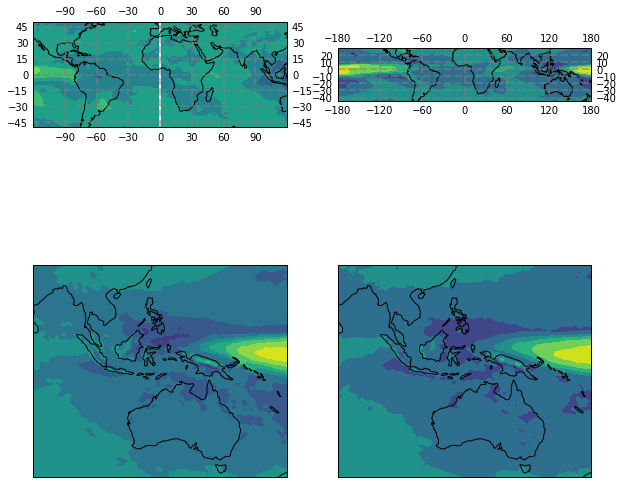

In [124]:
# PLOT CORRELATION COEFFICIENTS

fig = plt.figure(figsize=(10,10))

obs_lon = tsel2['obs'].lon
obs_lat = tsel2['obs'].lat
lon = tsel2['ctrl'].lon
lat = tsel2['ctrl'].lat

ax1 = plt.subplot(221, projection=ccrs.PlateCarree())
ax1.set_extent([120, -120, -50, 50], crs=ccrs.PlateCarree())
plt.contourf(obs_lon,obs_lat,r['obs'],transform=ccrs.PlateCarree())
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax2 = plt.subplot(222, projection=ccrs.PlateCarree())
ax2.set_extent([100, 200, -45, 30], crs=ccrs.PlateCarree())
plt.contourf(lon,lat,r['ctrl'],transform=ccrs.PlateCarree())
ax2.coastlines()
g2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax3 = plt.subplot(223, projection=ccrs.PlateCarree())
ax3.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())
plt.contourf(lon,lat,r['hitopo'],transform=ccrs.PlateCarree())
ax3.coastlines()

ax4 = plt.subplot(224, projection=ccrs.PlateCarree())
ax4.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())
plt.contourf(lon,lat,r['cam'],transform=ccrs.PlateCarree())
ax4.coastlines()


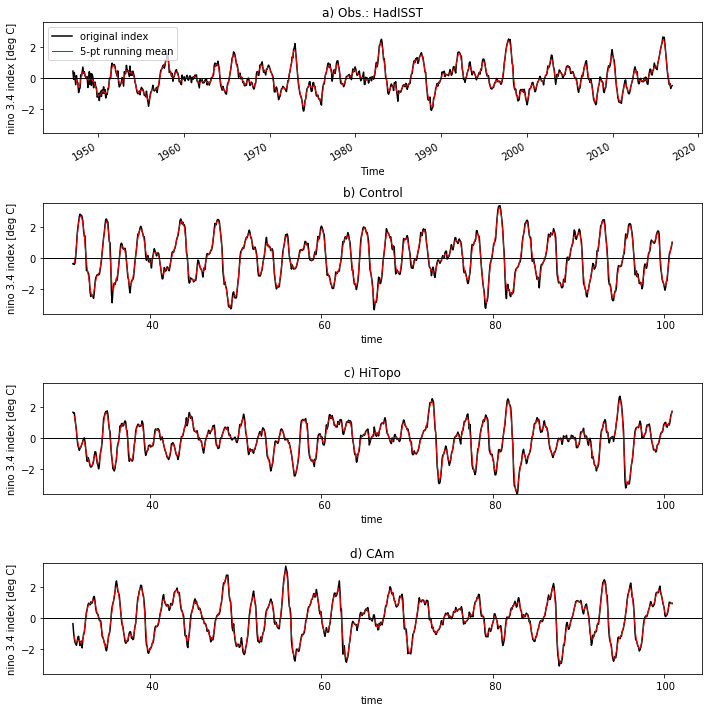

In [5]:
# ENSO Time Series

fig = plt.figure(figsize=(10,10))

ylim1 = -3.6
ylim2 = 3.6

ax1 = plt.subplot(4,1,1)
nino34['obs'].plot(color='k',label='original index')
nino34_5pt['obs'].plot(linewidth=1,color='r',label='5-pt running mean')
ax1.set_title('a) Obs.: HadISST')
ax1.set_ylabel('nino 3.4 index [deg C]')
ax1.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)
plt.legend()

ax2 = plt.subplot(4,1,2)
nino34['ctrl'].sel(time= slice('0031','0100')).plot(color='k')
nino34_5pt['ctrl'].sel(time = slice('0031','0100')).plot(linewidth=1,color='r')
ax2.set_title('b) Control')
ax2.set_ylabel('nino 3.4 index [deg C]')
ax2.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)

ax3 = plt.subplot(4,1,3)
nino34['hitopo'].sel(time = slice('0031','0100')).plot(color='k')
nino34_5pt['hitopo'].sel(time = slice('0031','0100')).plot(linewidth=1,color='r')
ax3.set_title('c) HiTopo')
ax3.set_ylabel('nino 3.4 index [deg C]')
ax3.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)

ax4 = plt.subplot(4,1,4)
nino34['cam'].sel(time = slice('0031','0100')).plot(color='k')
nino34_5pt['cam'].sel(time = slice('0031','0100')).plot(linewidth=1,color='r')
ax4.set_title('d) CAm')
ax4.set_ylabel('nino 3.4 index [deg C]')
ax4.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)

plt.tight_layout()

#plt.savefig('nino34_timeseries.png', dpi = 600)

In [8]:
# Power spectra calculation
def powerspectra(nino):
    x = nino.rolling(time=3, center=True).mean().dropna('time')
    freq, spectra = signal.welch(x, fs=12, detrend='linear',scaling='density',window='boxcar') #boxcar is same as daniell
    power = spectra*freq*np.log(2)
    powernorm = power/np.max(power)
    return freq, power, powernorm

freq34 = {}
power34 = {}
powernorm34 = {}
freq3 = {}
power3 = {}
powernorm3 = {}
freq34_sst = {}
power34_sst = {}
powernorm34_sst = {}
freq3_sst = {}
power3_sst = {}
powernorm3_sst = {}
for key in ['obs', 'hitopo', 'ctrl', 'cam', 'ctrl_ccsm', 'cam_ccsm']:
    freq34[key], power34[key], powernorm34[key] = powerspectra(nino34[key])
    freq3[key], power3[key], powernorm3[key] = powerspectra(nino3[key])
    freq34_sst[key], power34_sst[key], powernorm34_sst[key] = powerspectra(nino34_sst[key])
    freq3_sst[key], power3_sst[key], powernorm3_sst[key] = powerspectra(nino3_sst[key])

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/

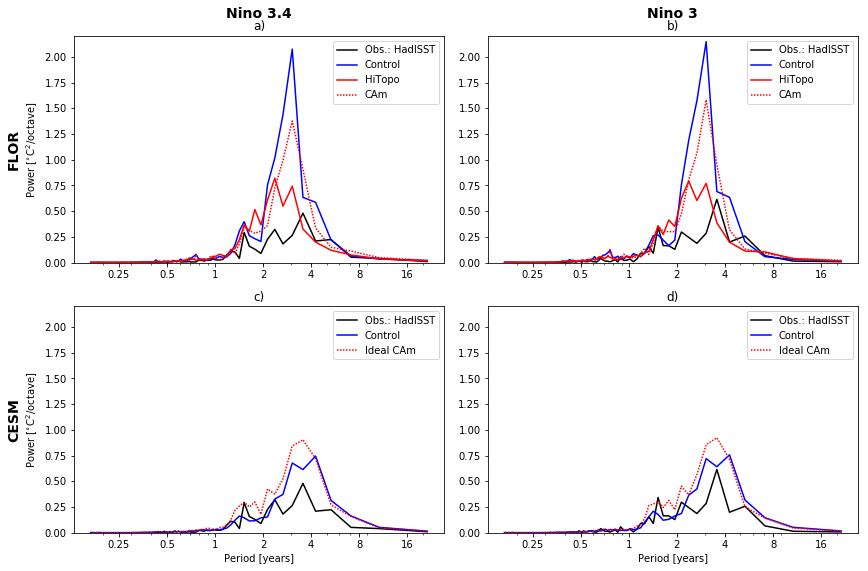

In [7]:
# Power Spectra

fig = plt.figure(figsize=(12,8))

ylim1 = 0
ylim2 = 2.2
xlim1 = 0
xlim2 = 16
fs = 12

ax1 = plt.subplot(2,2,1)
plt.plot(1/freq34['obs'], power34['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34['ctrl'], power34['ctrl'],color='b',label='Control')
plt.plot(1/freq34['hitopo'], power34['hitopo'],color='r',label='HiTopo')
plt.plot(1/freq34['cam'], power34['cam'],color='r',dashes=[1,1,1,1],label='CAm')

ax1.set_title('a)')
ax1.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
#ax1.set_xlabel('Period [years]')
ax1.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax2 = plt.subplot(2,2,2)
plt.plot(1/freq3['obs'], power3['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3['ctrl'], power3['ctrl'],color='b',label='Control')
plt.plot(1/freq3['hitopo'], power3['hitopo'],color='r',label='HiTopo')
plt.plot(1/freq3['cam'], power3['cam'],color='r',dashes=[1,1,1,1],label='CAm')

ax2.set_title('b)')
#ax2.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
#ax2.set_xlabel('Period [years]')
ax2.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax3 = plt.subplot(2,2,3)
plt.plot(1/freq34['obs'], power34['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34['ctrl_ccsm'], power34['ctrl_ccsm'],color='b',label='Control')
plt.plot(1/freq34['cam_ccsm'], power34['cam_ccsm'],color='r',dashes=[1,1,1,1],label='Ideal CAm')

ax3.set_title('c)')
ax3.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
ax3.set_xlabel('Period [years]')
ax3.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax4 = plt.subplot(2,2,4)
plt.plot(1/freq3['obs'], power3['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3['ctrl_ccsm'], power3['ctrl_ccsm'],color='b',label='Control')
plt.plot(1/freq3['cam_ccsm'], power3['cam_ccsm'],color='r',dashes=[1,1,1,1],label='Ideal CAm')

ax4.set_title('d)')
#ax4.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
ax4.set_xlabel('Period [years]')
ax4.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

#labels
ax1.text(0.5,1.08,'Nino 3.4',fontsize = 14, transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.08,'Nino 3',fontsize = 14, transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.18,0.5,'FLOR',fontsize = 14, transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.18,0.5,'CESM',fontsize = 14, transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')

plt.tight_layout()

plt.savefig('enso_powerspectra.png')

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/

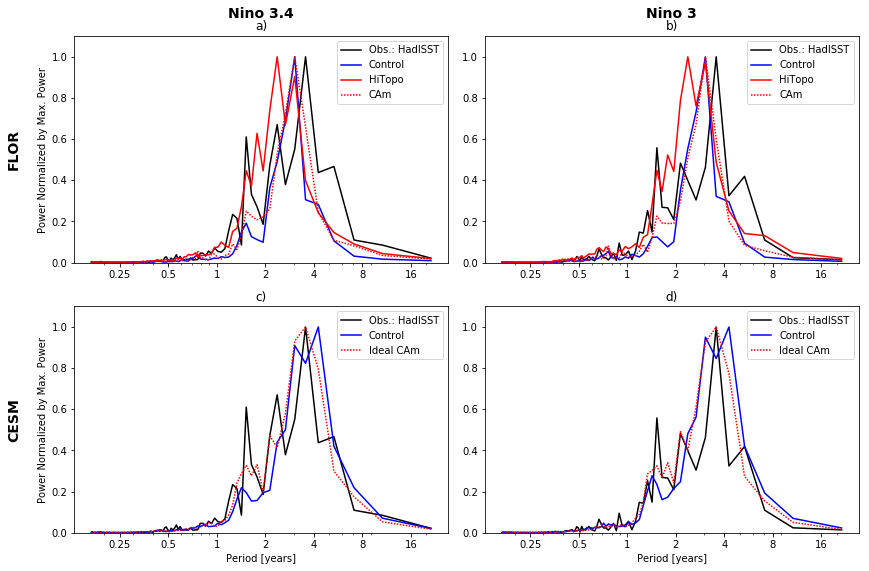

In [8]:
# Power Spectra Normalized

fig = plt.figure(figsize=(12,8))

ylim1 = 0
ylim2 = 1.1
xlim1 = 0
xlim2 = 16
fs = 12

ax1 = plt.subplot(2,2,1)
plt.plot(1/freq34['obs'], powernorm34['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34['ctrl'], powernorm34['ctrl'],color='b',label='Control')
plt.plot(1/freq34['hitopo'], powernorm34['hitopo'],color='r',label='HiTopo')
plt.plot(1/freq34['cam'], powernorm34['cam'],color='r',dashes=[1,1,1,1],label='CAm')

ax1.set_title('a)')
ax1.set_ylabel(r'Power Normalized by Max. Power')
#ax1.set_xlabel('Period [years]')
ax1.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax2 = plt.subplot(2,2,2)
plt.plot(1/freq3['obs'], powernorm3['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3['ctrl'], powernorm3['ctrl'],color='b',label='Control')
plt.plot(1/freq3['hitopo'], powernorm3['hitopo'],color='r',label='HiTopo')
plt.plot(1/freq3['cam'], powernorm3['cam'],color='r',dashes=[1,1,1,1],label='CAm')

ax2.set_title('b)')
#ax2.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
#ax2.set_xlabel('Period [years]')
ax2.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax3 = plt.subplot(2,2,3)
plt.plot(1/freq34['obs'], powernorm34['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34['ctrl_ccsm'], powernorm34['ctrl_ccsm'],color='b',label='Control')
plt.plot(1/freq34['cam_ccsm'], powernorm34['cam_ccsm'],color='r',dashes=[1,1,1,1],label='Ideal CAm')

ax3.set_title('c)')
ax3.set_ylabel(r'Power Normalized by Max. Power')
ax3.set_xlabel('Period [years]')
ax3.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax4 = plt.subplot(2,2,4)
plt.plot(1/freq3['obs'], powernorm3['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3['ctrl_ccsm'], powernorm3['ctrl_ccsm'],color='b',label='Control')
plt.plot(1/freq3['cam_ccsm'], powernorm3['cam_ccsm'],color='r',dashes=[1,1,1,1],label='Ideal CAm')

ax4.set_title('d)')
#ax4.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
ax4.set_xlabel('Period [years]')
ax4.set_ylim([ylim1, ylim2])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

#labels
ax1.text(0.5,1.08,'Nino 3.4',fontsize = 14, transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.08,'Nino 3',fontsize = 14, transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.18,0.5,'FLOR',fontsize = 14, transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.18,0.5,'CESM',fontsize = 14, transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')

plt.tight_layout()

plt.savefig('enso_powernormspectra.png')

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/

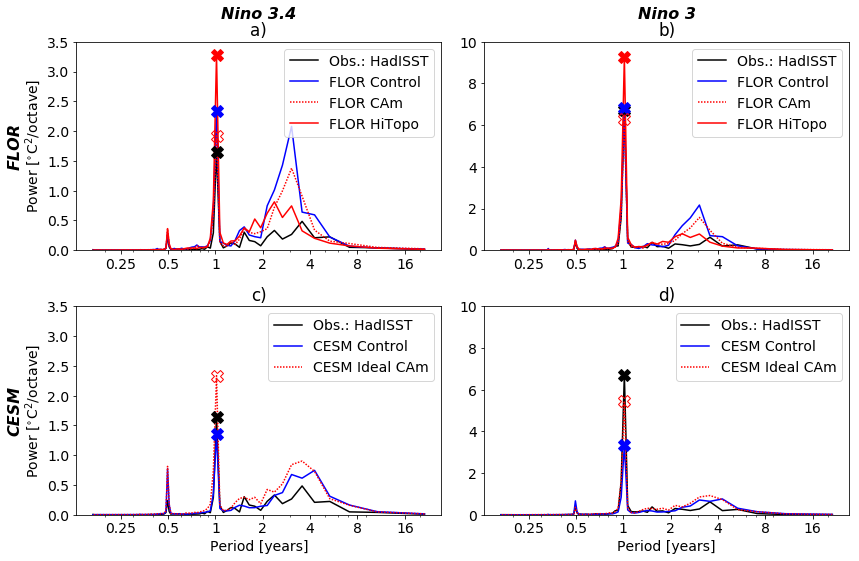

In [18]:
# Power Spectra Plus Seasonal Cycle

fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
fs_label = 16

ylim1 = 0
ylim2_34 = 3.5
ylim2_3 = 10
xlim1 = 0
xlim2 = 16
fs = 12

i = np.argmax(power34_sst['hitopo'])
ms = 12 #markersize

ax1 = plt.subplot(2,2,1)
plt.plot(1/freq34_sst['obs'], power34_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34_sst['ctrl'], power34_sst['ctrl'],color='b',label='FLOR Control')
plt.plot(1/freq34_sst['cam'], power34_sst['cam'],color='r',dashes=[1,1,1,1],label='FLOR CAm')
plt.plot(1/freq34_sst['hitopo'], power34_sst['hitopo'],color='r',label='FLOR HiTopo')
# Markers of 1 year amplitude
plt.plot(1/freq34_sst['obs'][i],power34_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq34_sst['ctrl'][i],power34_sst['ctrl'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq34_sst['cam'][i],power34_sst['cam'][i],marker='X',color='r',markersize=ms,fillstyle='none')
plt.plot(1/freq34_sst['hitopo'][i],power34_sst['hitopo'][i],marker='X',color='r',markersize=ms)
ax1.set_title('a)')
ax1.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
#ax1.set_xlabel('Period [years]')
ax1.set_ylim([ylim1, ylim2_34])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax2 = plt.subplot(2,2,2)
plt.plot(1/freq3_sst['obs'], power3_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3_sst['ctrl'], power3_sst['ctrl'],color='b',label='FLOR Control')
plt.plot(1/freq3_sst['cam'], power3_sst['cam'],color='r',dashes=[1,1,1,1],label='FLOR CAm')
plt.plot(1/freq3_sst['hitopo'], power3_sst['hitopo'],color='r',label='FLOR HiTopo')
# Markers of 1 year amplitude
plt.plot(1/freq3_sst['obs'][i],power3_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq3_sst['ctrl'][i],power3_sst['ctrl'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq3_sst['cam'][i],power3_sst['cam'][i],marker='X',color='r',markersize=ms,fillstyle='none')
plt.plot(1/freq3_sst['hitopo'][i],power3_sst['hitopo'][i],marker='X',color='r',markersize=ms)
ax2.set_title('b)')
#ax2.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
#ax2.set_xlabel('Period [years]')
ax2.set_ylim([ylim1, ylim2_3])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax3 = plt.subplot(2,2,3)
plt.plot(1/freq34_sst['obs'], power34_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34_sst['ctrl_ccsm'], power34_sst['ctrl_ccsm'],color='b',label='CESM Control')
plt.plot(1/freq34_sst['cam_ccsm'], power34_sst['cam_ccsm'],color='r',dashes=[1,1,1,1],label='CESM Ideal CAm')
# Markers of 1 year amplitude
plt.plot(1/freq34_sst['obs'][i],power34_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq34_sst['ctrl_ccsm'][i],power34_sst['ctrl_ccsm'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq34_sst['cam_ccsm'][i],power34_sst['cam_ccsm'][i],marker='X',color='r',markersize=ms,fillstyle='none')
ax3.set_title('c)')
ax3.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
ax3.set_xlabel('Period [years]')
ax3.set_ylim([ylim1, ylim2_34])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax4 = plt.subplot(2,2,4)
plt.plot(1/freq3_sst['obs'], power3_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3_sst['ctrl_ccsm'], power3_sst['ctrl_ccsm'],color='b',label='CESM Control')
plt.plot(1/freq3_sst['cam_ccsm'], power3_sst['cam_ccsm'],color='r',dashes=[1,1,1,1],label='CESM Ideal CAm')
# Markers of 1 year amplitude
plt.plot(1/freq3_sst['obs'][i],power3_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq3_sst['ctrl_ccsm'][i],power3_sst['ctrl_ccsm'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq3_sst['cam_ccsm'][i],power3_sst['cam_ccsm'][i],marker='X',color='r',markersize=ms,fillstyle='none')
ax4.set_title('d)')
#ax4.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
ax4.set_xlabel('Period [years]')
ax4.set_ylim([ylim1, ylim2_3])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

#labels
ax1.text(0.5,1.11,'Nino 3.4',fontsize = fs_label, style = 'italic', transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.11,'Nino 3',fontsize = fs_label,  style = 'italic', transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.19,0.5,'FLOR',fontsize = fs_label, style = 'italic', transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.19,0.5,'CESM',fontsize = fs_label, style = 'italic', transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')

plt.tight_layout()

plt.savefig('enso_powerspectra_seasonal.pdf')
plt.savefig('enso_powerspectra_seasonal.png', xpixels = 600)

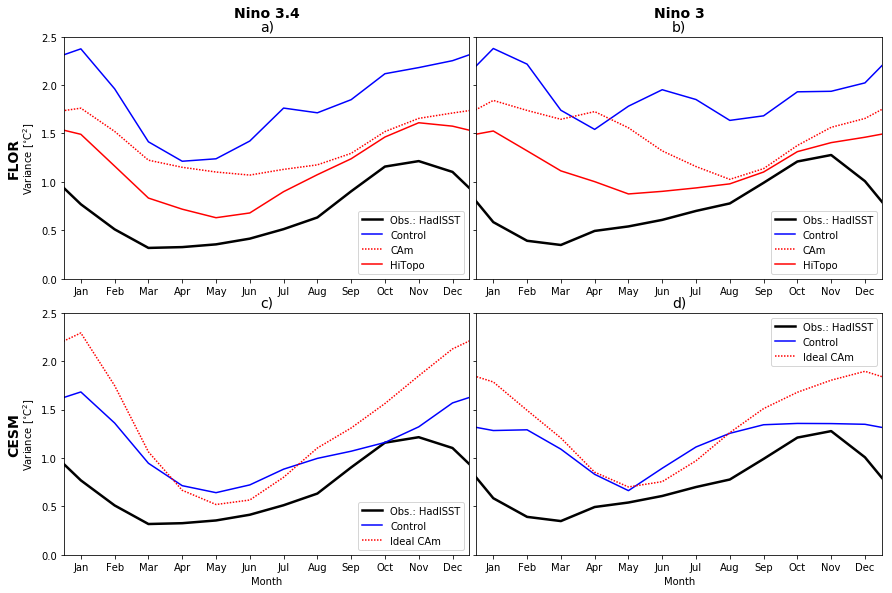

In [12]:
# Seasonal Cycle of Nino variance

fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,2,1)
Vx3 = {}
for key in variance34.keys():
    x = np.array(variance34[key])
    Vx3[key] = np.concatenate((x,x,x))
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl'], color = 'b', label = 'Control')
plt.plot(Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'CAm')
plt.plot(Vx3['hitopo'], color = 'r', label = 'HiTopo')
#plt.ylabel('nino 3.4 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([0,2.5])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.ylabel(r'Variance [$^{\circ}$C$^{2}$]')
plt.title('a)',fontsize=14)

ax2 = plt.subplot(2,2,2)
Vx3 = {}
for key in variance3.keys():
    x = np.array(variance3[key])
    Vx3[key] = np.concatenate((x,x,x))
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl'], color = 'b', label = 'Control')
plt.plot(Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'CAm')
plt.plot(Vx3['hitopo'], color = 'r', label = 'HiTopo')
#plt.ylabel('nino 3 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([0,2.5])
ax2.set_yticklabels([])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.title('b)',fontsize=14)

ax3 = plt.subplot(2,2,3)
Vx3 = {}
for key in variance34.keys():
    x = np.array(variance34[key])
    Vx3[key] = np.concatenate((x,x,x))
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl_ccsm'], color = 'b', label = 'Control')
plt.plot(Vx3['cam_ccsm'], color = 'r', dashes=[1,1,1,1], label = 'Ideal CAm')
#plt.ylabel('nino 3.4 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([0,2.5])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.ylabel(r'Variance [$^{\circ}$C$^{2}$]')
plt.title('c)',fontsize=14)

ax4 = plt.subplot(2,2,4)
Vx3 = {}
for key in variance3.keys():
    x = np.array(variance3[key])
    Vx3[key] = np.concatenate((x,x,x))
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl_ccsm'], color = 'b', label = 'Control')
plt.plot(Vx3['cam_ccsm'], color = 'r', dashes=[1,1,1,1], label = 'Ideal CAm')
#plt.ylabel('nino 3 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([0,2.5])
ax4.set_yticklabels([])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.title('d)',fontsize=14)

#labels
ax1.text(0.5,1.08,'Nino 3.4',fontsize = 14, transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.08,'Nino 3',fontsize = 14, transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.14,0.5,'FLOR',fontsize = 14, transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.14,0.5,'CESM',fontsize = 14, transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')


plt.tight_layout(pad = 0)

plt.savefig('twomodels_nino_var.png', bbox_inches='tight', dpi = 600)


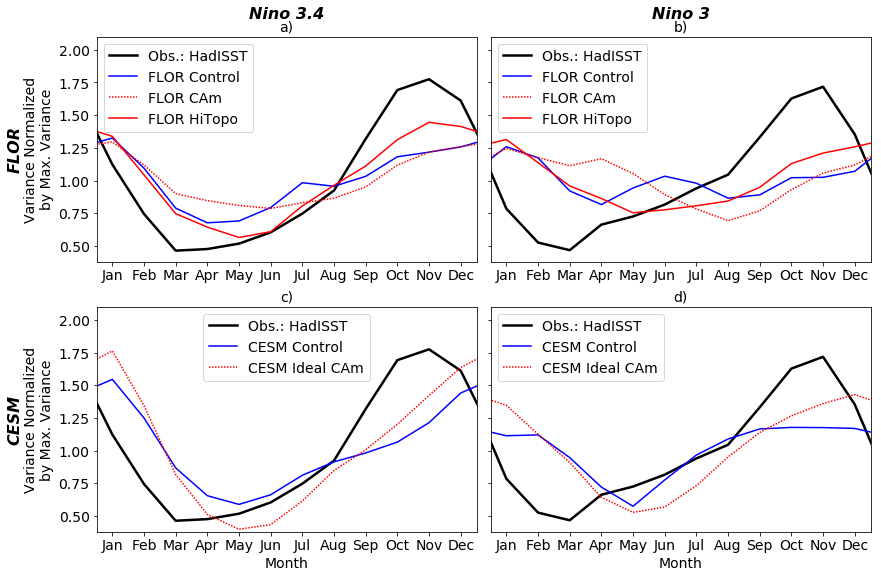

In [31]:
# Seasonal Cycle of Nino variance normalized

fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
fs_label = 16

ylim1 = 0.38
ylim2 = 2.1

ax1 = plt.subplot(2,2,1)
Vx3 = {}
for key in variance34.keys():
    x = np.array(variance34[key])
    Vx3[key] = np.concatenate((x,x,x))
    Vx3[key] = Vx3[key]/np.mean(x)
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl'], color = 'b', label = 'FLOR Control')
plt.plot(Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'FLOR CAm')
plt.plot(Vx3['hitopo'], color = 'r', label = 'FLOR HiTopo')
#plt.ylabel('nino 3.4 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([ylim1,ylim2])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.ylabel('Variance Normalized\nby Max. Variance')
plt.title('a)',fontsize=14)

ax2 = plt.subplot(2,2,2)
Vx3 = {}
for key in variance3.keys():
    x = np.array(variance3[key])
    Vx3[key] = np.concatenate((x,x,x))
    Vx3[key] = Vx3[key]/np.mean(x)
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl'], color = 'b', label = 'FLOR Control')
plt.plot(Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'FLOR CAm')
plt.plot(Vx3['hitopo'], color = 'r', label = 'FLOR HiTopo')
#plt.ylabel('nino 3 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([ylim1,ylim2])
ax2.set_yticklabels([])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.title('b)',fontsize=14)

ax3 = plt.subplot(2,2,3)
Vx3 = {}
for key in variance34.keys():
    x = np.array(variance34[key])
    Vx3[key] = np.concatenate((x,x,x))
    Vx3[key] = Vx3[key]/np.mean(x)
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl_ccsm'], color = 'b', label = 'CESM Control')
plt.plot(Vx3['cam_ccsm'], color = 'r', dashes=[1,1,1,1], label = 'CESM Ideal CAm')
#plt.ylabel('nino 3.4 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([ylim1,ylim2])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.ylabel('Variance Normalized\nby Max. Variance')
plt.title('c)',fontsize=14)

ax4 = plt.subplot(2,2,4)
Vx3 = {}
for key in variance3.keys():
    x = np.array(variance3[key])
    Vx3[key] = np.concatenate((x,x,x))
    Vx3[key] = Vx3[key]/np.mean(x)
plt.plot(Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.plot(Vx3['ctrl_ccsm'], color = 'b', label = 'CESM Control')
plt.plot(Vx3['cam_ccsm'], color = 'r', dashes=[1,1,1,1], label = 'CESM Ideal CAm')
#plt.ylabel('nino 3 index variance')
plt.legend()
plt.xlim([0.5,12.5])
plt.ylim([ylim1,ylim2])
ax4.set_yticklabels([])
plt.xticks(np.arange(1, 13, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.title('d)',fontsize=14)

#labels
ax1.text(0.5,1.08,'Nino 3.4',fontsize = fs_label, style='italic', transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.08,'Nino 3',fontsize = fs_label, style='italic', transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.235,0.5,'FLOR',fontsize = fs_label, style='italic', transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.235,0.5,'CESM',fontsize = fs_label, style='italic', transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')


plt.tight_layout(pad = 0.5)

plt.savefig('twomodels_nino_var_norm.pdf')

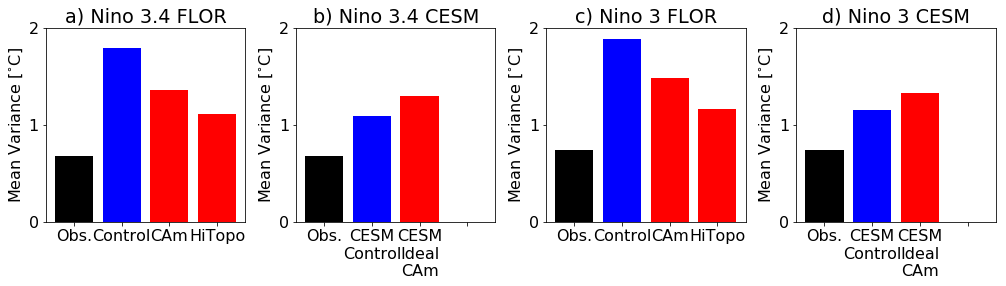

In [46]:
fig = plt.figure(figsize=(14,4))
plt.rcParams.update({'font.size': 16})


varmean34 = {}
varmean3 = {}
for key in variance34.keys():
    varmean34[key] = variance34[key].mean(dim='month')
    varmean3[key] = variance3[key].mean(dim='month')

ymin = 0
ymax = 2

# Nino 3.4 FLOR
ax1 = plt.subplot(141)
plt.bar(np.arange(1,5,1),np.array([varmean34['obs'],varmean34['ctrl'],varmean34['cam'],varmean34['hitopo']]),  color=['black', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,5,1), ('Obs.', 'Control', 'CAm','HiTopo'))
ax1.set_title('a) Nino 3.4 FLOR')
plt.yticks([0,1,2])
ax1.set_ylabel('Mean Variance [$^{\circ}$C]')

# Nino 3.4 CESM
ax2 = plt.subplot(142)
plt.bar(np.arange(1,5,1),np.array([varmean34['obs'],varmean34['ctrl_ccsm'],varmean34['cam_ccsm'],0]),  color=['black', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,5,1), ('Obs.', 'CESM\nControl', 'CESM\nIdeal\nCAm',''))
ax2.set_title('b) Nino 3.4 CESM')
plt.yticks([0,1,2])
ax2.set_ylabel('Mean Variance [$^{\circ}$C]')

# Nino 3 FLOR
ax3 = plt.subplot(143)
plt.bar(np.arange(1,5,1),np.array([varmean3['obs'],varmean3['ctrl'],varmean3['cam'],varmean3['hitopo']]), color=['black', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,5,1), ('Obs.', 'Control', 'CAm','HiTopo'))
ax3.set_title('c) Nino 3 FLOR')
plt.yticks([0,1,2])
ax3.set_ylabel('Mean Variance [$^{\circ}$C]')

# Nino 3 CESM
ax4 = plt.subplot(144)
plt.bar(np.arange(1,5,1),np.array([varmean3['obs'],varmean3['ctrl_ccsm'],varmean3['cam_ccsm'],0]), color=['black', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,5,1), ('Obs.', 'CESM\nControl', 'CESM\nIdeal\nCAm', ''))
ax4.set_title('d) Nino 3 CESM')
plt.yticks([0,1,2])
ax4.set_ylabel('Mean Variance [$^{\circ}$C]')

plt.tight_layout(pad = 0.5)

plt.savefig('ninovarmag.pdf', bbox_inches='tight')

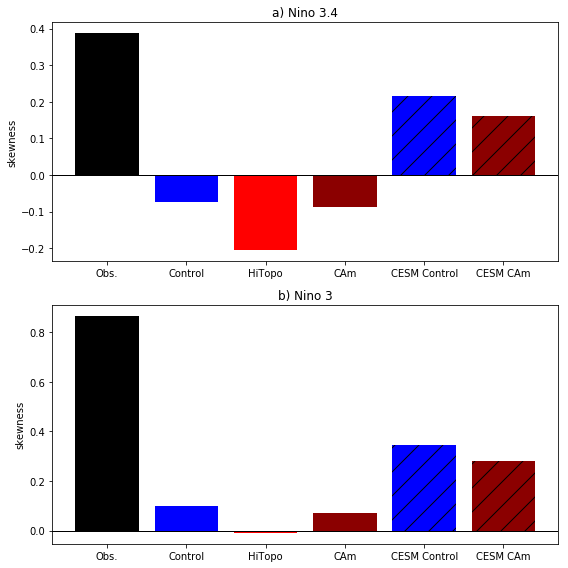

In [21]:
# Skewness

fig = plt.figure(figsize=(8,8))

x = np.arange(0,6)

ax3= plt.subplot(211)
skew34bar1 = [skew34['obs'],skew34['ctrl'],skew34['hitopo'],skew34['cam']]
skew34bar2 = [skew34['ctrl_ccsm'],skew34['cam_ccsm']]
plt.bar(np.arange(0,4),skew34bar1,color=['black', 'blue', 'red', 'darkred'])
plt.bar(np.arange(4,6),skew34bar2,color=['blue', 'darkred'],hatch='/')
plt.axhline(color='k',linewidth=1)
plt.xticks(x, ('Obs.', 'Control', 'HiTopo','CAm','CESM Control','CESM CAm'))
plt.ylabel('skewness')
plt.title('a) Nino 3.4')

ax4= plt.subplot(212)
skew3bar1 = [skew3['obs'],skew3['ctrl'],skew3['hitopo'],skew3['cam']]
skew3bar2 = [skew3['ctrl_ccsm'],skew3['cam_ccsm']]
plt.bar(np.arange(0,4),skew3bar1,color=['black', 'blue', 'red', 'darkred'])
plt.bar(np.arange(4,6),skew3bar2,color=['blue', 'darkred'],hatch='/')
plt.axhline(color='k',linewidth=1)
plt.xticks(x, ('Obs.', 'Control', 'HiTopo','CAm','CESM Control','CESM CAm'))
plt.ylabel('skewness')
plt.title('b) Nino 3')

plt.tight_layout()

plt.savefig('enso_skew.pdf')